# Required Assignment 17.1 — Comparing Classifiers (Bank Marketing)
Nicholas Cross

**Goal:** Compare k-nearest neighbors (KNN), logistic regression, decision trees, and support vector machines (SVM) to predict whether a client subscribes to a term deposit (`y`).

## 1. Business Problem
The bank runs outbound phone campaigns to offer term deposits. Calls have a cost (agent time) and a potential payoff (subscription). We want to **prioritize which clients to call** to maximize conversions and reduce wasted calls.

This is a **binary classification** problem. Because the positive class (`y=yes`) is typically rarer, we focus on **F1** and **recall** for the positive class, not accuracy alone.

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.stats import chi2_contingency, ttest_ind

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, recall_score, precision_score, roc_auc_score, RocCurveDisplay
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


## 2. Load Data
We use the UCI Bank Marketing dataset (`bank-additional-full.csv`).

In [3]:
# Load dataset (robust path handling)
candidate_paths = [
    Path("data/bank-additional-full.csv"),
    Path("./data/bank-additional-full.csv"),
    Path("../data/bank-additional-full.csv"),
]

data_path = None
for p in candidate_paths:
    if p.exists():
        data_path = p
        break

if data_path is None:
    raise FileNotFoundError("Could not find bank-additional-full.csv")

df = pd.read_csv(data_path, sep=';')
df.shape, df.head()

((41188, 21),
    age        job  marital    education  default housing loan    contact  \
 0   56  housemaid  married     basic.4y       no      no   no  telephone   
 1   57   services  married  high.school  unknown      no   no  telephone   
 2   37   services  married  high.school       no     yes   no  telephone   
 3   40     admin.  married     basic.6y       no      no   no  telephone   
 4   56   services  married  high.school       no      no  yes  telephone   
 
   month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
 0   may         mon  ...         1    999         0  nonexistent          1.1   
 1   may         mon  ...         1    999         0  nonexistent          1.1   
 2   may         mon  ...         1    999         0  nonexistent          1.1   
 3   may         mon  ...         1    999         0  nonexistent          1.1   
 4   may         mon  ...         1    999         0  nonexistent          1.1   
 
    cons.price.idx  cons.con

## 3. Data Understanding
### 3.1 Target distribution (class imbalance)

,count,percent
y,,
no,36548,88.73
yes,4640,11.27


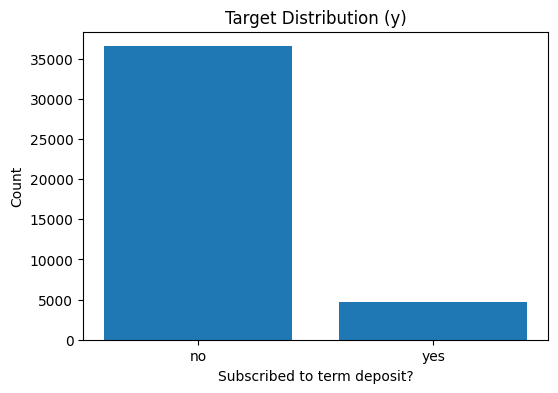

In [4]:
target_counts = df["y"].value_counts()
target_pct = df["y"].value_counts(normalize=True) * 100
display(pd.DataFrame({"count": target_counts, "percent": target_pct.round(2)}))

plt.figure(figsize=(6,4))
plt.bar(target_counts.index.astype(str), target_counts.values)
plt.title("Target Distribution (y)")
plt.xlabel("Subscribed to term deposit?")
plt.ylabel("Count")
plt.show()

### 3.2 Descriptive statistics

In [5]:
numeric_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
numeric_cols, cat_cols[:5], len(cat_cols)

(['age',
  'duration',
  'campaign',
  'pdays',
  'previous',
  'emp.var.rate',
  'cons.price.idx',
  'cons.conf.idx',
  'euribor3m',
  'nr.employed'],
 ['job', 'marital', 'education', 'default', 'housing'],
 11)

In [6]:
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


### 3.3 Key plots
**Note on leakage:** `duration` (call length) is known after/during the call. It may be unusable for deciding *who to call*.
We will evaluate models both **with** and **without** `duration`.

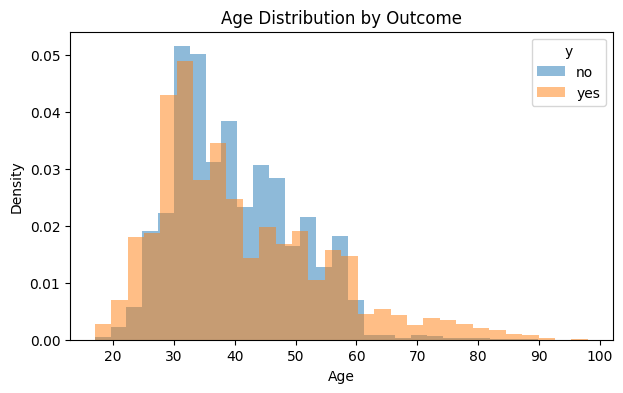

<Figure size 700x400 with 0 Axes>

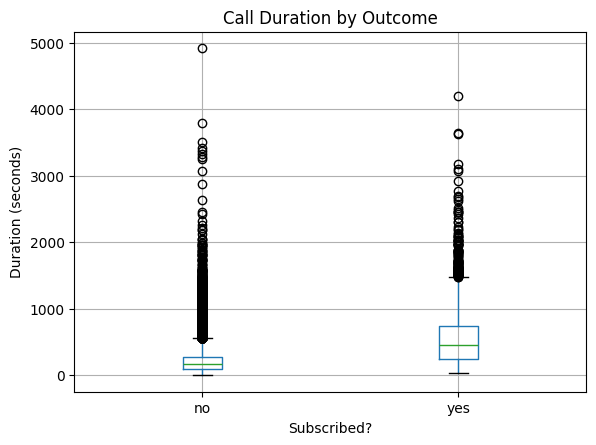

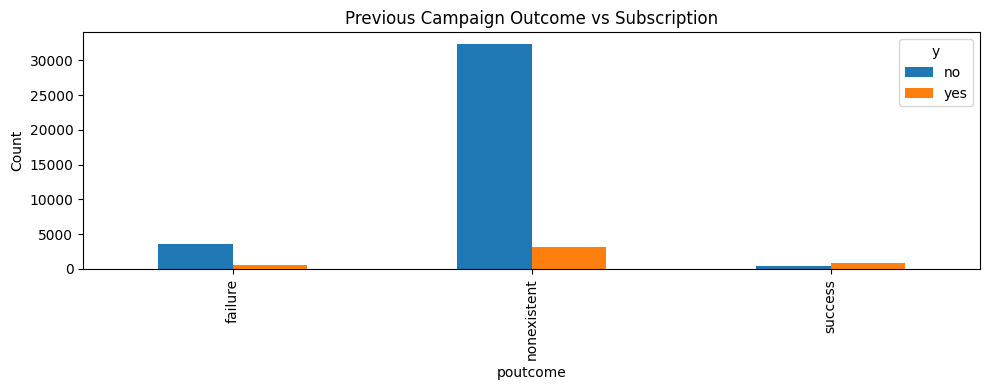

In [7]:
# Age distribution by outcome
plt.figure(figsize=(7,4))
for label in ["no", "yes"]:
    subset = df.loc[df["y"] == label, "age"]
    plt.hist(subset, bins=30, alpha=0.5, density=True, label=label)
plt.title("Age Distribution by Outcome")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend(title="y")
plt.show()

# Duration boxplot by outcome
plt.figure(figsize=(7,4))
df.boxplot(column="duration", by="y")
plt.title("Call Duration by Outcome")
plt.suptitle("")
plt.xlabel("Subscribed?")
plt.ylabel("Duration (seconds)")
plt.show()

# Previous campaign outcome vs subscription
ct = pd.crosstab(df["poutcome"], df["y"])
ct.plot(kind="bar", figsize=(10,4))
plt.title("Previous Campaign Outcome vs Subscription")
plt.xlabel("poutcome")
plt.ylabel("Count")
plt.legend(title="y")
plt.tight_layout()
plt.show()

## 4. Inferential statistics (quick checks)
- **Chi-square** tests for association between selected categorical variables and `y`
- A simple mean comparison (Welch t-test) for `age` across outcomes

In [8]:
cat_to_test = ["job", "marital", "education", "contact", "month", "poutcome"]

chi_results = []
for c in cat_to_test:
    ct = pd.crosstab(df[c], df["y"])
    chi2, p, dof, exp = chi2_contingency(ct)
    chi_results.append({"feature": c, "chi2": chi2, "dof": dof, "p_value": p})

pd.DataFrame(chi_results).sort_values("p_value")

,feature,chi2,dof,p_value
5,poutcome,4230.523798,2,0.000000e+00
4,month,3101.149351,9,0.000000e+00
0,job,961.242440,11,4.189763e-199
3,contact,862.318364,1,1.525986e-189
2,education,193.105905,7,3.305189e-38
1,marital,122.655152,3,2.068015e-26


In [9]:
age_yes = df.loc[df["y"]=="yes", "age"]
age_no = df.loc[df["y"]=="no", "age"]
t_stat, p_val = ttest_ind(age_yes, age_no, equal_var=False)

summary = pd.DataFrame({
    "group": ["yes", "no"],
    "mean_age": [age_yes.mean(), age_no.mean()],
    "std_age": [age_yes.std(), age_no.std()],
    "n": [len(age_yes), len(age_no)]
})
summary, (t_stat, p_val)

(  group   mean_age    std_age      n
 0   yes  40.913147  13.837476   4640
 1    no  39.911185   9.898132  36548,
 (np.float64(4.779542781151716), np.float64(1.8047932698425662e-06)))

## 5. Preprocessing
We encode the target as 1/0, one-hot encode categoricals, and scale numerics. We keep a stratified train/test split.

We build:
1) `X_all` (includes `duration`)
2) `X_no_duration` (excludes `duration` for pre-call targeting)

In [10]:
df_model = df.copy()
df_model["y"] = (df_model["y"] == "yes").astype(int)

X_all = df_model.drop(columns=["y"])
y = df_model["y"]
X_no_duration = X_all.drop(columns=["duration"])

X_train_all, X_test_all, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)
X_train_nodur, X_test_nodur, _, _ = train_test_split(
    X_no_duration, y, test_size=0.2, random_state=42, stratify=y
)

numeric_cols_all = X_all.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols_all = X_all.select_dtypes(include=["object"]).columns.tolist()

numeric_cols_nodur = X_no_duration.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols_nodur = X_no_duration.select_dtypes(include=["object"]).columns.tolist()

X_train_all.shape, X_train_nodur.shape

((32950, 20), (32950, 19))

## 6. Modeling + Evaluation
We use **Stratified 5-fold CV** and **GridSearchCV**.
Primary selection metric: **F1** for the positive class (`y=1`).

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def build_preprocessor(numeric_cols, cat_cols):
    return ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ],
        remainder="drop"
    )

def evaluate_best_model(best_estimator, X_test, y_test, title="Model"):
    y_pred = best_estimator.predict(X_test)

    y_proba = None
    if hasattr(best_estimator, "predict_proba"):
        y_proba = best_estimator.predict_proba(X_test)[:, 1]
    elif hasattr(best_estimator, "decision_function"):
        scores = best_estimator.decision_function(X_test)
        y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

    print(f"=== {title} ===")
    print(classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(values_format="d")
    plt.title(f"Confusion Matrix — {title}")
    plt.show()

    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"ROC Curve — {title}")
        plt.show()

    return {
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    }

## 7. Train + Tune Models (with `duration`)
Upper-bound performance.

In [12]:
pre_all = build_preprocessor(numeric_cols_all, cat_cols_all)

models = {
    "KNN": (KNeighborsClassifier(), {
        "model__n_neighbors": [5, 15],
        "model__weights": ["uniform", "distance"],
    }),
    "LogisticRegression": (LogisticRegression(max_iter=2000, class_weight="balanced"), {
        "model__C": [0.5, 1.0, 2.0],
    }),
    "DecisionTree": (DecisionTreeClassifier(class_weight="balanced", random_state=42), {
        "model__max_depth": [3, 5, None],
        "model__min_samples_split": [2, 20],
        "model__min_samples_leaf": [1, 10],
    }),
    "SVC_RBF": (SVC(kernel="rbf", probability=False, class_weight="balanced"), {
        "model__C": [1.0, 5.0],
        "model__gamma": ["scale", 0.1],
    })
}

results_all = []
best_models_all = {}

for name, (est, param_grid) in models.items():
    pipe = Pipeline(steps=[("pre", pre_all), ("model", est)])
    gs = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring="f1", n_jobs=-1, verbose=0)
    gs.fit(X_train_all, y_train)

    best_models_all[name] = gs.best_estimator_
    results_all.append({"model": name, "best_f1_cv": gs.best_score_, "best_params": gs.best_params_})

pd.DataFrame(results_all).sort_values("best_f1_cv", ascending=False)

,model,best_f1_cv,best_params
2,DecisionTree,0.588352,"{'model__max_depth': None, 'model__min_samples..."
3,SVC_RBF,0.586861,"{'model__C': 1.0, 'model__gamma': 0.1}"
1,LogisticRegression,0.582582,{'model__C': 2.0}
0,KNN,0.475313,"{'model__n_neighbors': 5, 'model__weights': 'u..."


=== KNN (with duration) ===
              precision    recall  f1-score   support

           0      0.932     0.966     0.949      7310
           1      0.625     0.447     0.521       928

    accuracy                          0.908      8238
   macro avg      0.779     0.707     0.735      8238
weighted avg      0.898     0.908     0.901      8238



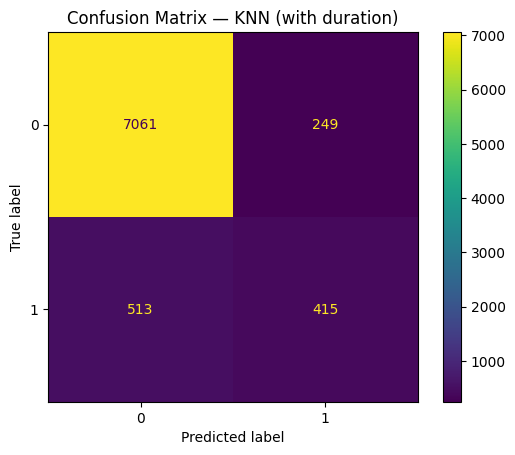

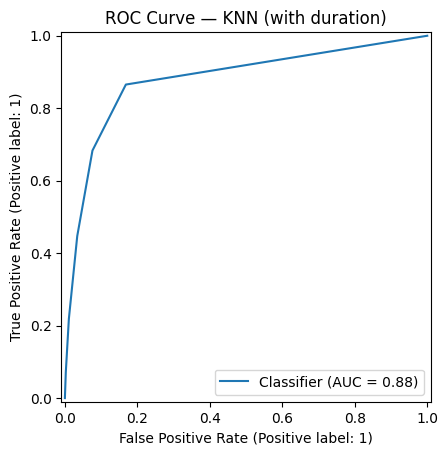

=== LogisticRegression (with duration) ===
              precision    recall  f1-score   support

           0      0.987     0.859     0.919      7310
           1      0.451     0.912     0.604       928

    accuracy                          0.865      8238
   macro avg      0.719     0.886     0.761      8238
weighted avg      0.927     0.865     0.883      8238



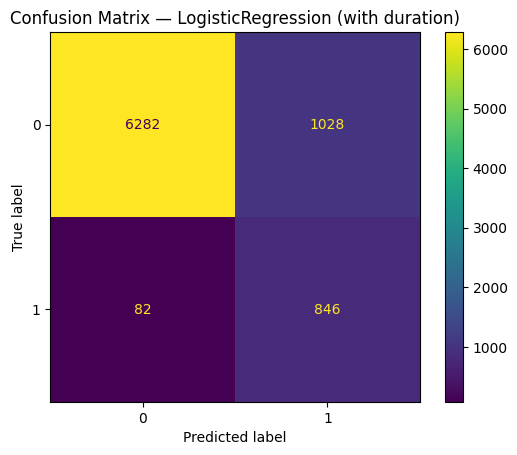

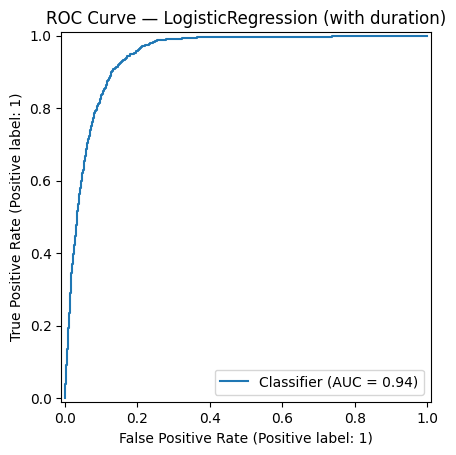

=== DecisionTree (with duration) ===
              precision    recall  f1-score   support

           0      0.980     0.880     0.927      7310
           1      0.475     0.856     0.611       928

    accuracy                          0.877      8238
   macro avg      0.727     0.868     0.769      8238
weighted avg      0.923     0.877     0.891      8238



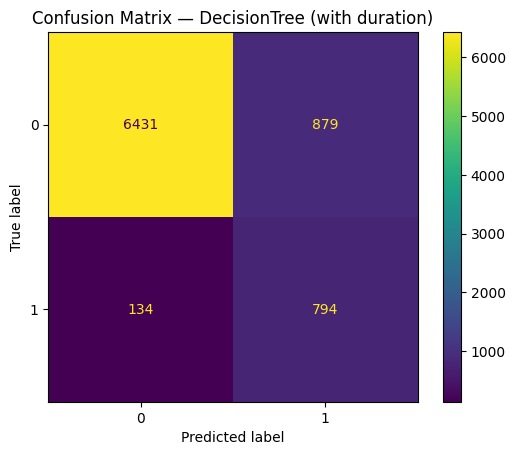

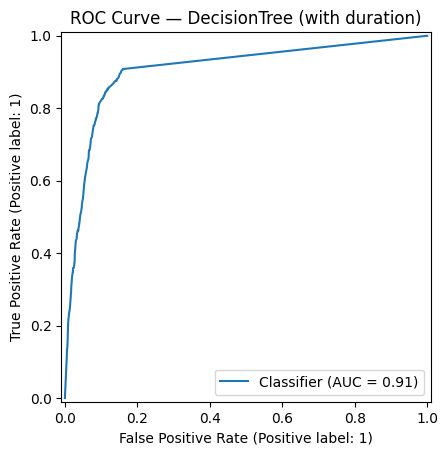

=== SVC_RBF (with duration) ===
              precision    recall  f1-score   support

           0      0.988     0.856     0.917      7310
           1      0.447     0.915     0.601       928

    accuracy                          0.863      8238
   macro avg      0.717     0.886     0.759      8238
weighted avg      0.927     0.863     0.882      8238



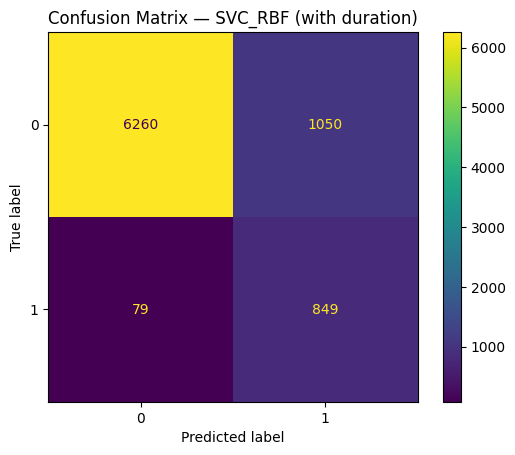

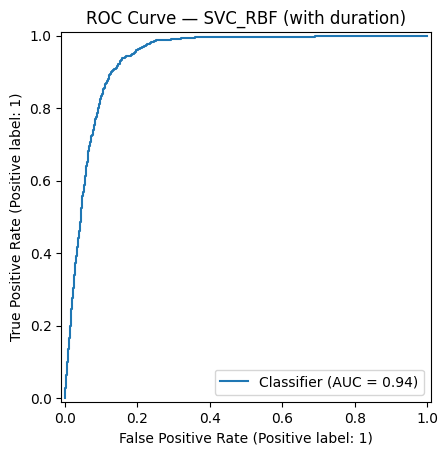

,precision,recall,f1,roc_auc
model,,,,
DecisionTree,0.474597,0.855603,0.610534,0.906341
LogisticRegression,0.451441,0.911638,0.603854,0.943809
SVC_RBF,0.447077,0.914871,0.600637,0.939045
KNN,0.625000,0.447198,0.521357,0.879859


In [13]:
test_metrics_all = []
for name, best_est in best_models_all.items():
    metrics = evaluate_best_model(best_est, X_test_all, y_test, title=f"{name} (with duration)")
    metrics["model"] = name
    test_metrics_all.append(metrics)

pd.DataFrame(test_metrics_all).set_index("model").sort_values("f1", ascending=False)

## 8. Train + Tune Models (without `duration`)
More realistic for pre-call targeting.

In [14]:
pre_nodur = build_preprocessor(numeric_cols_nodur, cat_cols_nodur)

results_nodur = []
best_models_nodur = {}

for name, (est, param_grid) in models.items():
    pipe = Pipeline(steps=[("pre", pre_nodur), ("model", est)])
    gs = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring="f1", n_jobs=-1, verbose=0)
    gs.fit(X_train_nodur, y_train)

    best_models_nodur[name] = gs.best_estimator_
    results_nodur.append({"model": name, "best_f1_cv": gs.best_score_, "best_params": gs.best_params_})

pd.DataFrame(results_nodur).sort_values("best_f1_cv", ascending=False)

,model,best_f1_cv,best_params
3,SVC_RBF,0.469280,"{'model__C': 1.0, 'model__gamma': 'scale'}"
2,DecisionTree,0.450362,"{'model__max_depth': 3, 'model__min_samples_le..."
1,LogisticRegression,0.448511,{'model__C': 2.0}
0,KNN,0.360401,"{'model__n_neighbors': 5, 'model__weights': 'u..."


=== KNN (no duration) ===
              precision    recall  f1-score   support

           0      0.917     0.973     0.944      7310
           1      0.584     0.304     0.400       928

    accuracy                          0.897      8238
   macro avg      0.750     0.638     0.672      8238
weighted avg      0.879     0.897     0.882      8238



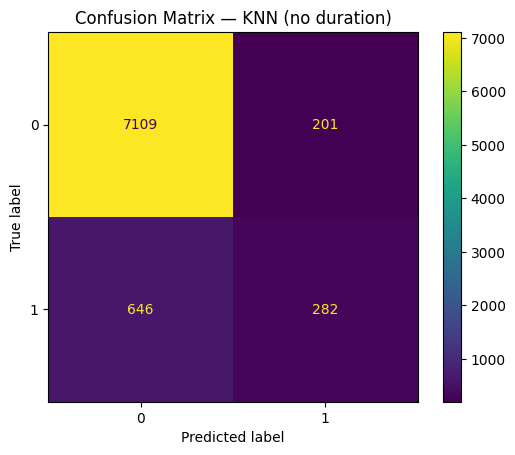

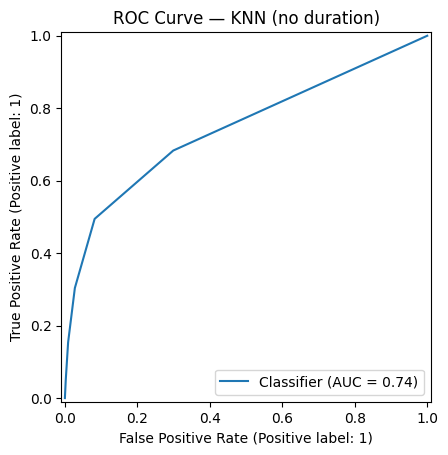

=== LogisticRegression (no duration) ===
              precision    recall  f1-score   support

           0      0.950     0.859     0.902      7310
           1      0.368     0.645     0.469       928

    accuracy                          0.835      8238
   macro avg      0.659     0.752     0.686      8238
weighted avg      0.885     0.835     0.854      8238



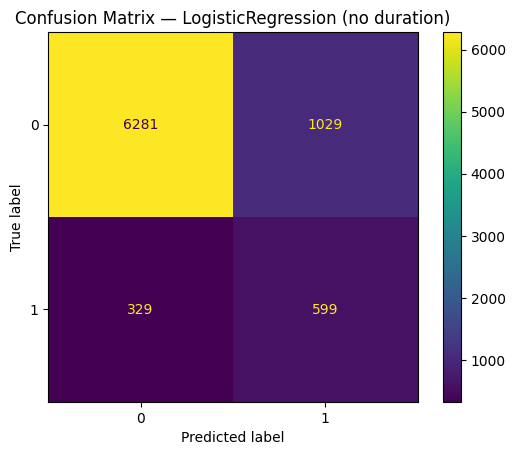

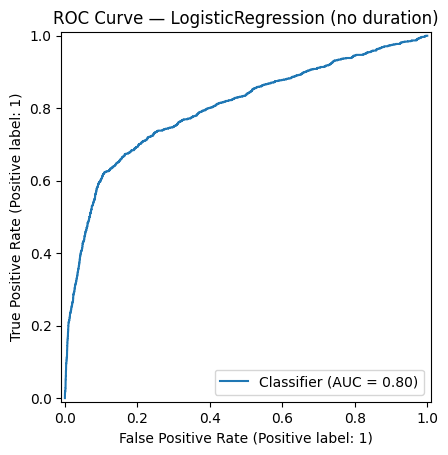

=== DecisionTree (no duration) ===
              precision    recall  f1-score   support

           0      0.946     0.877     0.910      7310
           1      0.385     0.609     0.472       928

    accuracy                          0.846      8238
   macro avg      0.666     0.743     0.691      8238
weighted avg      0.883     0.846     0.861      8238



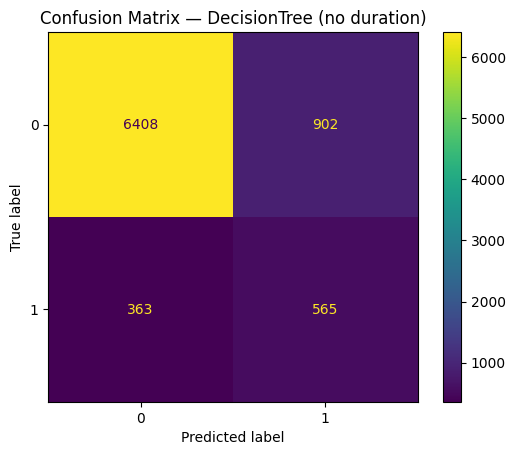

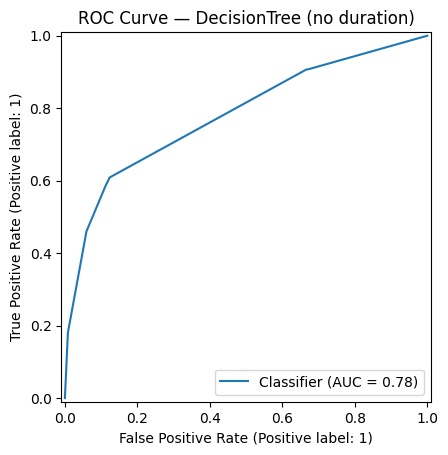

=== SVC_RBF (no duration) ===
              precision    recall  f1-score   support

           0      0.950     0.886     0.917      7310
           1      0.414     0.633     0.500       928

    accuracy                          0.858      8238
   macro avg      0.682     0.759     0.709      8238
weighted avg      0.890     0.858     0.870      8238



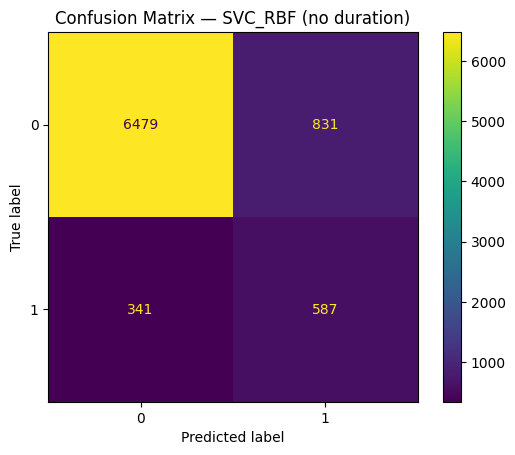

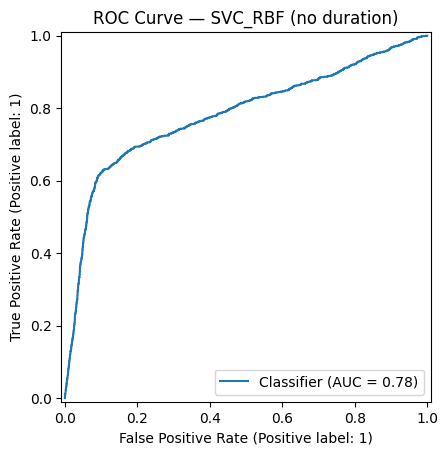

,precision,recall,f1,roc_auc
model,,,,
SVC_RBF,0.413963,0.632543,0.500426,0.782843
DecisionTree,0.385140,0.608836,0.471816,0.780846
LogisticRegression,0.367936,0.645474,0.468701,0.800918
KNN,0.583851,0.303879,0.399717,0.744470


In [15]:
test_metrics_nodur = []
for name, best_est in best_models_nodur.items():
    metrics = evaluate_best_model(best_est, X_test_nodur, y_test, title=f"{name} (no duration)")
    metrics["model"] = name
    test_metrics_nodur.append(metrics)

pd.DataFrame(test_metrics_nodur).set_index("model").sort_values("f1", ascending=False)

## 9. Interpretability
### 9.1 Logistic Regression coefficients (no-duration)
We show the largest positive/negative coefficients as a stakeholder-friendly explanation.

In [16]:
def get_feature_names(preprocessor, numeric_cols, cat_cols):
    ohe = preprocessor.named_transformers_["cat"]
    cat_feature_names = ohe.get_feature_names_out(cat_cols)
    return np.concatenate([np.array(numeric_cols), cat_feature_names])

lr_best = best_models_nodur["LogisticRegression"]
pre = lr_best.named_steps["pre"]
model = lr_best.named_steps["model"]

feature_names = get_feature_names(pre, numeric_cols_nodur, cat_cols_nodur)
coef_df = pd.DataFrame({"feature": feature_names, "coef": model.coef_.ravel()})

top_pos = coef_df.sort_values("coef", ascending=False).head(15)
top_neg = coef_df.sort_values("coef", ascending=True).head(15)

top_pos, top_neg

(                 feature      coef
 49             month_mar  1.297542
 5         cons.price.idx  1.173455
 45             month_aug  0.491821
 8            nr.employed  0.471004
 46             month_dec  0.452915
 7              euribor3m  0.394972
 14           job_retired  0.350996
 29  education_illiterate  0.318069
 42      contact_cellular  0.302570
 61      poutcome_success  0.269916
 24       marital_unknown  0.268499
 17           job_student  0.159403
 53             month_sep  0.112349
 58       day_of_week_wed  0.111105
 33            default_no  0.110371,
                           feature      coef
 4                    emp.var.rate -2.355450
 48                      month_jun -0.859056
 50                      month_may -0.652346
 51                      month_nov -0.592554
 43              contact_telephone -0.330986
 59               poutcome_failure -0.310786
 44                      month_apr -0.249398
 2                           pdays -0.248106
 21               

### 9.2 Decision Tree feature importances (no-duration)

In [17]:
dt_best = best_models_nodur["DecisionTree"]
pre = dt_best.named_steps["pre"]
tree = dt_best.named_steps["model"]

feature_names = get_feature_names(pre, numeric_cols_nodur, cat_cols_nodur)
imp_df = pd.DataFrame({"feature": feature_names, "importance": tree.feature_importances_}).sort_values("importance", ascending=False)
imp_df.head(20)

,feature,importance
8,nr.employed,0.767885
6,cons.conf.idx,0.154189
5,cons.price.idx,0.041976
2,pdays,0.018036
34,default_unknown,0.012059
43,contact_telephone,0.005142
1,campaign,0.000714
3,previous,0.000000
4,emp.var.rate,0.000000
9,job_admin.,0.000000


## 10. Findings (Actionable Insights)
- **Don’t use accuracy alone** due to class imbalance; use **F1/recall**.
- `duration` boosts performance but is not usable for *pre-call* decisions.
- For *pre-call targeting*, pick the best **no-duration** model to rank customers for calling.
- Keep an interpretable model (Logistic Regression or shallow Decision Tree) for explaining drivers.

**Recommendation:** Use model scores to build a prioritized call list, then tune the decision threshold based on how many calls the team can place per day.

## 11. Next Steps
- Add cost-sensitive evaluation (profit per call) using business values for TP/FP/FN.
- Calibrate probabilities and tune thresholds to match campaign capacity.
- Benchmark ensembles (Random Forest / Gradient Boosting) as a follow-up.
- Consider a temporal split if campaigns are time-dependent (avoid look-ahead bias).